# 锂电池SPMe模型几何参数的Sobol敏感性分析

本项目旨在使用Sobol方法，分析锂离子电池单粒子模型（SPMe）中几何参数的敏感性。主要工具为`pybamm`（电池建模与仿真）和`salib`（敏感性分析）。

## 已有的工作

一些项目和讨论提及了 PyBaMM 中的参数敏感性分析，例如[Mrzhang-hub/pybamm-param-sensitivities 项目](https://github.com/Mrzhang-hub/pybamm-param-sensitivities) 和 [PyBaMM Discourse 上的相关主题](https://pybamm.discourse.group/t/questions-on-checking-sensitivities/103) 。
但是，这些工作主要集中在电化学和材料参数的敏感性分析；而很少涉及几何参数（如电极厚度、隔膜厚度、颗粒半径等）的敏感性分析。
这主要是因为电化学和材料参数容易借助 PyBaMM 的内置功能进行修改和分析，而几何参数的敏感性分析通常需要更复杂的模型结构和网格划分，甚至涉及控制方程和求解器的变化。

## 核心库

-   **PyBaMM (Python Battery Mathematical Modelling)**：一个开源Python电池建模包，支持DFN、SPM、SPMe等多种模型。PyBaMM提供灵活框架，用于电池行为仿真、参数估计和实验设计，能快速构建并求解复杂的电化学与热物理模型。

-   **SALib (Sensitivity Analysis Library in Python)**：一个Python敏感性分析库，提供Sobol、Morris、FAST等方法。SALib帮助理解模型输出对输入参数变化的敏感度，识别关键参数及交互作用，可用于模型参数不确定性量化和重要性排序。 

以下是一个利用Pybamm进行电池建模、求解和结果可视化的示例。

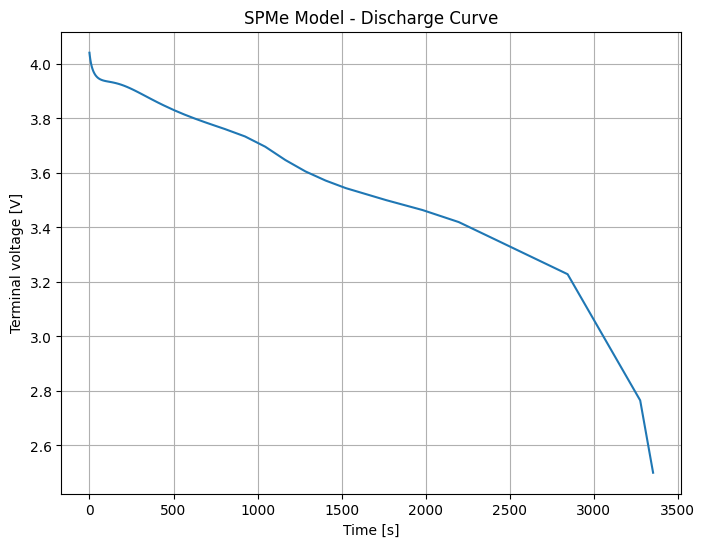

In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# 关闭 Warning，不影响最终结果
pybamm.set_logging_level("ERROR")

# 1. 定义 SPMe 模型
model = pybamm.lithium_ion.SPMe()

# 2. 设置参数
# 使用 PyBaMM 内置的参数集，例如 Chen2020
param = pybamm.ParameterValues("Chen2020")

# 更新特定的几何参数：
param["Negative electrode thickness [m]"] = 80e-6
param["Positive electrode thickness [m]"] = 70e-6
param["Separator thickness [m]"] = 20e-6
param["Negative particle radius [m]"] = 5e-6
param["Positive particle radius [m]"] = 5e-6

# 3. 定义实验
# 例如，1C 放电直到 2.5V
experiment = pybamm.Experiment(["Discharge at 1C until 2.5 V"])

# 4. 创建仿真
sim = pybamm.Simulation(model, experiment=experiment, parameter_values=param)

# 5. 求解模型
solution = sim.solve()

# 6. 绘制结果
# solution.plot()

# 提取电压和时间数据进行更精细的绘图
time_s = solution["Time [s]"].entries
voltage_V = solution["Terminal voltage [V]"].entries

plt.figure(figsize=(8, 6))
plt.plot(time_s, voltage_V)
plt.xlabel("Time [s]")
plt.ylabel("Terminal voltage [V]")
plt.title("SPMe Model - Discharge Curve")
plt.grid(True)
plt.show()

## 量化时间序列的差异

SPMe模型输出（如电压）是时间序列数据。敏感性分析需量化参数变化后输出曲线 $Y(t)$ 与基准曲线 $Y_b(t)$ 间的差异。参考 [appendix-sa.pdf](../docs/appendix-sa.pdf)，差异可分解为：

1.  **位置差异 ($\delta_p$)**: 衡量整体位置偏移。
    $$\delta_p[Y(t), Y_b(t)] = \text{mean}[Y(t)] - \text{mean}[Y_b(t)]$$

2.  **尺度差异 ($\delta_s$)**: 衡量幅度差异。
    $$\delta_s[Y(t), Y_b(t)] = (\max[Y(t)] - \min[Y(t)]) - (\max[Y_b(t)] - \min[Y_b(t)])$$

3.  **形状差异 ($\delta_r$)**: 衡量校正位置和尺度后的形状差异。在本研究中，我们使用均方根误差 (RMSE) 来量化形状差异：
    $$\delta_r[Y(t), Y_b(t)] = \text{RMSE}(Y(t), Y_b(t)) = \sqrt{\frac{1}{M} \sum_{i=1}^{M} (Y(t_i) - Y_b(t_i))^2}$$
    其中 $M$ 是评估时间点的数量。

本项目将采用综合差异指标 $\Delta_i = \delta_p + \delta_s + \delta_r$ 作为量化电压曲线 $V(t)$ 与基准电压曲线 $V_b(t)$ 之间综合差异的单一度量指标，并作为Sobol分析的目标函数输出。

In [2]:
from SALib.analyze import sobol
from SALib.sample import saltelli

# 2. 定义要分析的几何参数及其边界
# 参考 PyBaMM SPMe 文档和 Chen2020 参数集中的典型值
# 参数名称必须与 PyBaMM 中的参数字典键完全一致

# 获取默认参数值以确定合理的边界
default_param = pybamm.ParameterValues("Chen2020")

param_definitions = {
    "Negative electrode thickness [m]": {
        "default": default_param["Negative electrode thickness [m]"],
        "bounds_factor": 0.2,  # 变动 +/- 20%
    },
    "Positive electrode thickness [m]": {
        "default": default_param["Positive electrode thickness [m]"],
        "bounds_factor": 0.2,
    },
    "Separator thickness [m]": {
        "default": default_param["Separator thickness [m]"],
        "bounds_factor": 0.2,
    },
    "Negative particle radius [m]": {
        "default": default_param["Negative particle radius [m]"],
        "bounds_factor": 0.2,
    },
    "Positive particle radius [m]": {
        "default": default_param["Positive particle radius [m]"],
        "bounds_factor": 0.2,
    },
    # "Electrode height [m]": {
    #     "default": default_param["Electrode height [m]"],
    #     "bounds_factor": 0.2
    # },
    # "Electrode width [m]": {
    #     "default": default_param["Electrode width [m]"],
    #     "bounds_factor": 0.2
    # }
}

problem = {
    "num_vars": len(param_definitions),
    "names": list(param_definitions.keys()),
    "bounds": [],
}

for name, props in param_definitions.items():
    lower_bound = props["default"] * (1 - props["bounds_factor"])
    upper_bound = props["default"] * (1 + props["bounds_factor"])
    problem["bounds"].append([lower_bound, upper_bound])
    print(
        f"Parameter: {name}, Default: {props['default']:.2e}, Bounds: [{lower_bound:.2e}, {upper_bound:.2e}]"
    )

# 3. 生成参数样本 (SALib)
# N 是基础样本数量，对于 Sobol 分析，总样本量将是 N * (2D + 2) 或 N * (D + 2)
# D 是参数数量 (num_vars)
# 使用 N = 2**8 = 256 作为示例，实际分析可能需要更大的 N
# 如果计算资源允许，建议 N >= 1024
N_samples = 2 ** 8 # 5
calculate_second_order = True  # 是否计算二阶效应

param_values_salib = saltelli.sample(
    problem, N=N_samples, calc_second_order=calculate_second_order
)
print(
    f"\nGenerated {param_values_salib.shape[0]} parameter samples for Sobol analysis."
)

Parameter: Negative electrode thickness [m], Default: 8.52e-05, Bounds: [6.82e-05, 1.02e-04]
Parameter: Positive electrode thickness [m], Default: 7.56e-05, Bounds: [6.05e-05, 9.07e-05]
Parameter: Separator thickness [m], Default: 1.20e-05, Bounds: [9.60e-06, 1.44e-05]
Parameter: Negative particle radius [m], Default: 5.86e-06, Bounds: [4.69e-06, 7.03e-06]
Parameter: Positive particle radius [m], Default: 5.22e-06, Bounds: [4.18e-06, 6.26e-06]

Generated 3072 parameter samples for Sobol analysis.


In [3]:
# 4.1 定义基线仿真和通用的评估时间点

# 运行一次基线仿真
model_baseline = pybamm.lithium_ion.SPMe()
param_baseline = pybamm.ParameterValues("Chen2020")
experiment_baseline = pybamm.Experiment(["Discharge at 1C until 2.5 V"])
sim_baseline = pybamm.Simulation(
    model_baseline, experiment=experiment_baseline, parameter_values=param_baseline
)
sol_baseline = sim_baseline.solve()
t_eval_baseline = sol_baseline["Time [s]"].entries
voltage_baseline = sol_baseline["Terminal voltage [V]"].entries

# 为了确保所有仿真都在相同的时间点上进行比较，定义一个固定的时间向量 t_eval_common
# 使用基线仿真的最大时间，并插值到200个点
max_time_baseline = t_eval_baseline[-1]
t_eval_common = np.linspace(0, max_time_baseline, 200)  # 200 个评估点

# 对基线解在 t_eval_common 上进行插值
voltage_baseline_interp = np.interp(t_eval_common, t_eval_baseline, voltage_baseline)

print(
    "Baseline simulation complete and common evaluation time points (t_eval_common) prepared."
)
print(f"Baseline simulation ran for {max_time_baseline:.2f} seconds.")
print(
    f"Common evaluation time points range from {t_eval_common[0]:.2f}s to {t_eval_common[-1]:.2f}s with {len(t_eval_common)} points."
)


def evaluate_model_delta_i(parameter_sample):
    """
    运行 PyBaMM SPMe 模型并计算与基线电压曲线的综合差异指标 Delta_i.
    Delta_i = delta_p + delta_s + delta_r
    其中:
        delta_p: 位置差异 (mean_run - mean_baseline)
        delta_s: 尺度差异 ((max_run - min_run) - (max_baseline - min_baseline))
        delta_r: 形状差异 (RMSE(run, baseline))
    参数:
        parameter_sample (np.array): SALib 生成的参数样本。
    返回:
        float: 电压曲线的综合差异指标 Delta_i。
    """
    model_run = pybamm.lithium_ion.SPMe()
    param_run = pybamm.ParameterValues("Chen2020")  # 每次都从新的默认参数开始

    current_params = {}
    for i, name in enumerate(problem["names"]):
        current_params[name] = parameter_sample[i]

    try:
        param_run.update(current_params)
        sim_run = pybamm.Simulation(
            model_run, experiment=experiment_baseline, parameter_values=param_run
        )
        sol_run = sim_run.solve(t_eval=t_eval_common)
        voltage_run = sol_run["Terminal voltage [V]"].entries

        if len(voltage_run) < len(t_eval_common):
            padding_value = (
                voltage_run[-1]
                if len(voltage_run) > 0
                else param_run["Lower voltage cut-off [V]"]
            )
            voltage_run_padded = np.full_like(t_eval_common, padding_value)
            voltage_run_padded[: len(voltage_run)] = voltage_run
            voltage_run = voltage_run_padded

        # 计算 delta_p (位置差异)
        delta_p = np.mean(voltage_run) - np.mean(voltage_baseline_interp)

        # 计算 delta_s (尺度差异)
        range_run = np.max(voltage_run) - np.min(voltage_run)
        range_baseline = np.max(voltage_baseline_interp) - np.min(voltage_baseline_interp)
        delta_s = range_run - range_baseline

        # 计算 delta_r (形状差异 - RMSE)
        delta_r = np.sqrt(np.mean((voltage_run - voltage_baseline_interp) ** 2))

        # 计算综合差异指标 Delta_i
        # 注意：直接相加可能会因为各项尺度不同导致某一项主导。可以考虑加权或归一化，但按当前要求直接相加。
        delta_i = delta_p + delta_s + delta_r

        # print(f"Run with {current_params}, d_p={delta_p:.3f}, d_s={delta_s:.3f}, d_r={delta_r:.3f}, Delta_i={delta_i:.3f}")
        return delta_i

    except Exception as e:
        # print(f"Error during simulation with params {current_params}: {e}")
        return 1e6  # 一个较大的惩罚值


# 测试评估函数
if 'param_values_salib' in globals() and len(param_values_salib) > 0:
    test_sample_delta_i = param_values_salib[0]
    print(f"\nTesting new evaluation function 'evaluate_model_delta_i' with sample: {test_sample_delta_i}")
    output_test_delta_i = evaluate_model_delta_i(test_sample_delta_i)
    print(f"Test Delta_i: {output_test_delta_i:.4f}")
else:
    print("Skipping test of `evaluate_model_delta_i`: `param_values_salib` not found or empty.")

print("\nBaseline simulation and new evaluation function 'evaluate_model_delta_i' are set up.")

Baseline simulation complete and common evaluation time points (t_eval_common) prepared.
Baseline simulation ran for 3555.88 seconds.
Common evaluation time points range from 0.00s to 3555.88s with 200 points.

Testing new evaluation function 'evaluate_model_delta_i' with sample: [6.83596875e-05 7.55409375e-05 1.28531250e-05 5.37929688e-06
 5.80317187e-06]
Test Delta_i: 0.2490

Baseline simulation and new evaluation function 'evaluate_model_delta_i' are set up.


In [4]:
# 5. 执行 Sobol 分析

# 待求解的模型较多，因此使用 ProcessPoolExecutor 进行并行化

from concurrent.futures import ProcessPoolExecutor
import os

# 尝试获取 CPU 核心数，如果失败则默认为 2
try:
    num_workers = os.cpu_count()
    if num_workers is None:
        num_workers = 2
except NotImplementedError:
    num_workers = 2

print(
    f"Starting Sobol analysis with {param_values_salib.shape[0]} samples using up to {num_workers} workers..."
)
print("This may take a significant amount of time depending on N and model complexity.")

Y = np.zeros([param_values_salib.shape[0]])


# --- 并行执行 ---
with ProcessPoolExecutor(max_workers=num_workers) as executor:
    futures = [
        executor.submit(evaluate_model_delta_i, param_values_salib[i])  # MODIFIED HERE
        for i in range(param_values_salib.shape[0])
    ]

    # Iterate with tqdm for a progress bar
    for i, future in enumerate(
        tqdm(
            futures,
            desc="Simulating samples (parallel)",
            total=len(futures),
            unit="sample",
        )
    ):
        try:
            Y[i] = future.result()
        except Exception as e:
            # Use tqdm.write for messages when using a progress bar to avoid display issues
            tqdm.write(
                f"Error in parallel execution for sample {i} (params: {param_values_salib[i]}): {e}"
            )
            Y[i] = 1e6  # Assign a large error value
# --- 并行执行结束 ---

# # --- 串行执行 (更稳定，但较慢) ---
# # If you uncomment this block, ensure tqdm is imported (as done above)
# print("Starting serial execution (fallback or alternative)...") # Optional: indicate serial execution start
# for i in tqdm(range(param_values_salib.shape[0]), desc="Simulating samples (serial)", total=param_values_salib.shape[0], unit="sample"):
#     try:
#         Y[i] = evaluate_model_delta_i(param_values_salib[i]) # MODIFIED HERE
#     except Exception as e:
#         tqdm.write(f"Error in serial execution for sample {i} (params: {param_values_salib[i]}): {e}")
#         Y[i] = 1e6 # Assign a large error value
# # --- 串行执行结束 ---

print("\nAll simulations completed. Performing Sobol analysis...")

# 执行 Sobol 分析
Si = sobol.analyze(
    problem, Y, calc_second_order=calculate_second_order, print_to_console=False
)  # 使用之前定义的 calculate_second_order

print("Sobol analysis complete.")


Starting Sobol analysis with 3072 samples using up to 16 workers...
This may take a significant amount of time depending on N and model complexity.


Simulating samples (parallel):   0%|          | 0/3072 [00:00<?, ?sample/s]


All simulations completed. Performing Sobol analysis...
Sobol analysis complete.


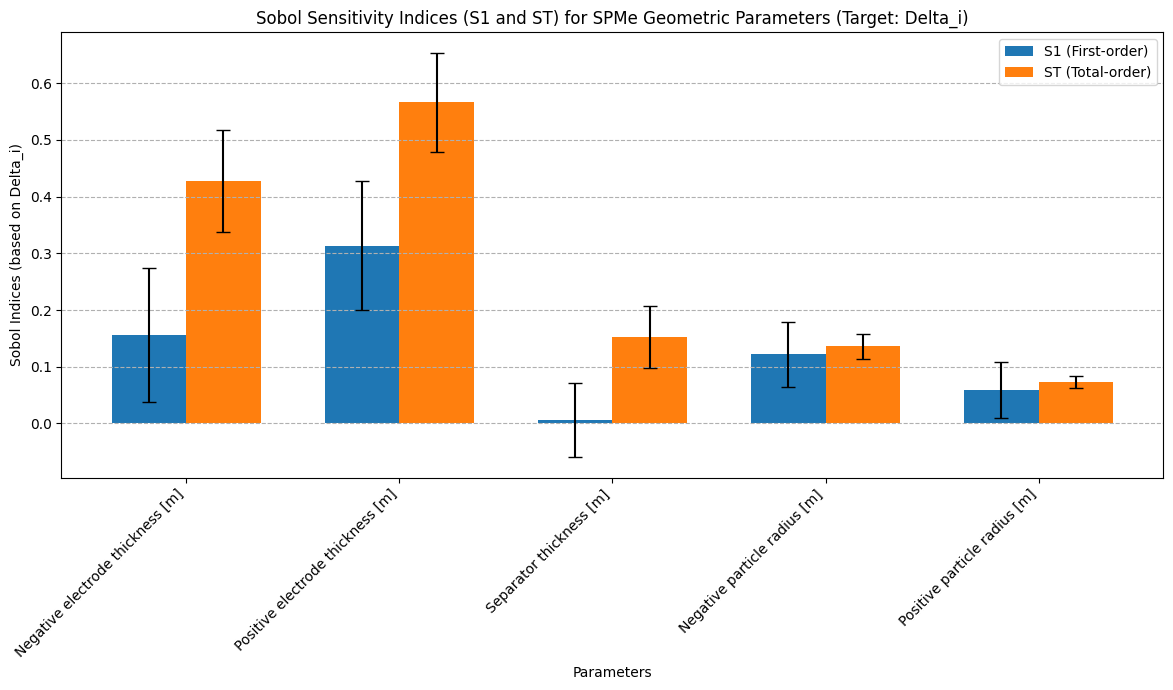


S1 and ST indices (based on Delta_i):
Negative electrode thickness [m]: S1 = 0.156 (conf: 0.118), ST = 0.428 (conf: 0.090)
Positive electrode thickness [m]: S1 = 0.314 (conf: 0.113), ST = 0.566 (conf: 0.088)
Separator thickness [m]: S1 = 0.005 (conf: 0.065), ST = 0.152 (conf: 0.054)
Negative particle radius [m]: S1 = 0.122 (conf: 0.058), ST = 0.136 (conf: 0.022)
Positive particle radius [m]: S1 = 0.059 (conf: 0.050), ST = 0.073 (conf: 0.011)


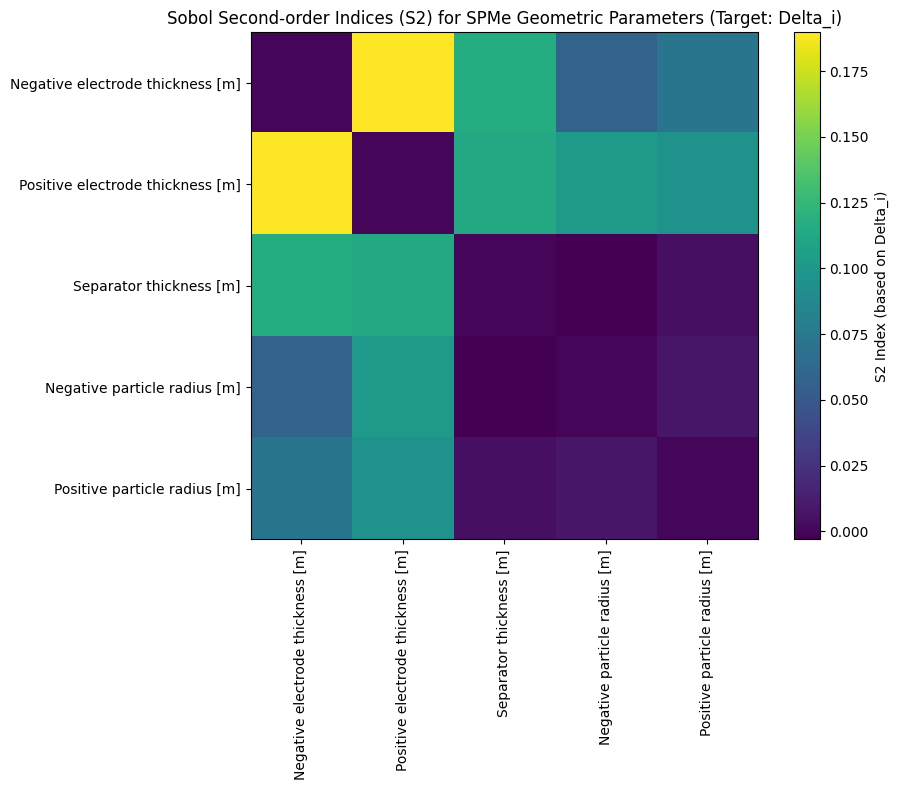


S2 indices (showing unique pairs, S_ij = S_ji, based on Delta_i):
(Negative electrode thickness [m], Positive electrode thickness [m]): S2 = 0.190 (conf: 0.163)
(Negative electrode thickness [m], Separator thickness [m]): S2 = 0.116 (conf: 0.149)
(Negative electrode thickness [m], Negative particle radius [m]): S2 = 0.059 (conf: 0.144)
(Negative electrode thickness [m], Positive particle radius [m]): S2 = 0.072 (conf: 0.136)
(Positive electrode thickness [m], Separator thickness [m]): S2 = 0.114 (conf: 0.144)
(Positive electrode thickness [m], Negative particle radius [m]): S2 = 0.102 (conf: 0.157)
(Positive electrode thickness [m], Positive particle radius [m]): S2 = 0.096 (conf: 0.147)
(Separator thickness [m], Negative particle radius [m]): S2 = -0.003 (conf: 0.104)
(Separator thickness [m], Positive particle radius [m]): S2 = 0.005 (conf: 0.097)
(Negative particle radius [m], Positive particle radius [m]): S2 = 0.008 (conf: 0.090)


In [5]:
# 6. 可视化结果
import os # Ensure os is imported for directory creation

# Create the results directory if it doesn't exist
os.makedirs("../results", exist_ok=True)

# 提取 S1, ST, S2 指数
S1 = Si["S1"]
ST = Si["ST"]
S2 = Si["S2"]  # S2 from SALib might be upper triangular or full with NaNs
S1_conf = Si["S1_conf"]
ST_conf = Si["ST_conf"]
S2_conf = Si["S2_conf"]

param_names = problem["names"]

# 绘制 S1 和 ST 指数
plt.figure(figsize=(12, 7))

bar_width = 0.35
index = np.arange(len(param_names))

plt.bar(index, S1, bar_width, yerr=S1_conf, label="S1 (First-order)", capsize=5)
plt.bar(
    index + bar_width, ST, bar_width, yerr=ST_conf, label="ST (Total-order)", capsize=5
)

plt.xlabel("Parameters")
plt.ylabel("Sobol Indices (based on Delta_i)")
plt.title("Sobol Sensitivity Indices (S1 and ST) for SPMe Geometric Parameters (Target: Delta_i)")
plt.xticks(index + bar_width / 2, param_names, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.grid(axis="y", linestyle="--")
plt.savefig('../results/sobol_s1_st_indices_delta_i.png', bbox_inches='tight') # Save the S1/ST plot
plt.show()

print("\nS1 and ST indices (based on Delta_i):")
for i, name in enumerate(param_names):
    print(
        f"{name}: S1 = {S1[i]:.3f} (conf: {S1_conf[i]:.3f}), ST = {ST[i]:.3f} (conf: {ST_conf[i]:.3f})"
    )

# 绘制 S2 指数的热力图
if calculate_second_order and S2 is not None:
    plt.figure(figsize=(10, 8))
    
    # Create a full symmetric matrix from the upper triangular S2 matrix
    S2_symmetric = np.copy(S2) # Start with a copy
    S2_symmetric[np.tril_indices(S2_symmetric.shape[0], k=-1)] = S2_symmetric.T[np.tril_indices(S2_symmetric.shape[0], k=-1)]
    
    # Convert NaNs (especially on the diagonal) to 0 for plotting
    S2_plot = np.nan_to_num(S2_symmetric, nan=0.0)

    im = plt.imshow(S2_plot, cmap="viridis")
    plt.colorbar(im, label="S2 Index (based on Delta_i)")

    plt.xticks(range(len(param_names)), param_names, rotation=90)
    plt.yticks(range(len(param_names)), param_names)
    plt.title("Sobol Second-order Indices (S2) for SPMe Geometric Parameters (Target: Delta_i)")
    plt.tight_layout()
    plt.savefig('../results/sobol_s2_heatmap_delta_i.png', bbox_inches='tight') # Save the S2 heatmap
    plt.show()

    print("\nS2 indices (showing unique pairs, S_ij = S_ji, based on Delta_i):")
    for i in range(len(param_names)):
        for j in range(i + 1, len(param_names)): # Iterates for i < j (upper triangle)
            conf_val_str = ""
            if S2_conf is not None and i < S2_conf.shape[0] and j < S2_conf.shape[1]:
                # Ensure S2_conf is also accessed correctly if it's upper triangular
                conf_val_str = f" (conf: {S2_conf[i, j]:.3f})"
            print(
                f"({param_names[i]}, {param_names[j]}): S2 = {S2[i, j]:.3f}{conf_val_str}"
            )
else:
    print("\nSecond-order indices (S2) were not calculated or are not available.")

## 结果说明


1.  **关键参数敏感性:**部分参数（如 `正极厚度`、`负极厚度`）表现出最高的S1和ST值，它们对模型输出影响最为显著，是设计和制造中需精密控制的核心因素。

2.  **参数交互效应:**S2热力图显示特定参数对（如 `正极厚度`与`负极厚度`）之间存在较强S2值，这些参数间存在显著的交互作用。

请注意，上述代码和分析仅为示例，其结果的正确性有待商榷。可以从增加分析的参数数量、精细化参数的采样范围、增加样本数量以及优化差异量化方法等进一步改进。
